# Analysis of a sample image of oil spill

## References:


1.   [A Review of Oil Spill Remote Sensing](https://www.mdpi.com/1424-8220/18/1/91)
2.   [Algorithm to Estimate Oil Spill Area Using Digital Properties of Image](https://www.joet.org/journal/view.php?number=2951)


## Summary of Approach:

Oil Spill analysis using visual imaging is cheap and effective, given favourable visibility, weather & light conditions. Assuming such conditions, oil spill can be typically spotted as a thin coat of silver surrounded by a rainbow or black/brown in color depending on the thickness of the oil in a given area. Using multispectral imaging like visual, thermal and SAR is recommended to help mitigate effect of environmental factors.

I will focus on using visual imaging i.e. colored images in HSV space to focus on isolating oil spill colors from the background.


In [1]:
!ls -lh

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np

total 96K
drwxr-xr-x 1 root root 4.0K Jun  1 13:40 sample_data
-rw-r--r-- 1 root root  90K Jun  5 10:46 spill_oil.jpg


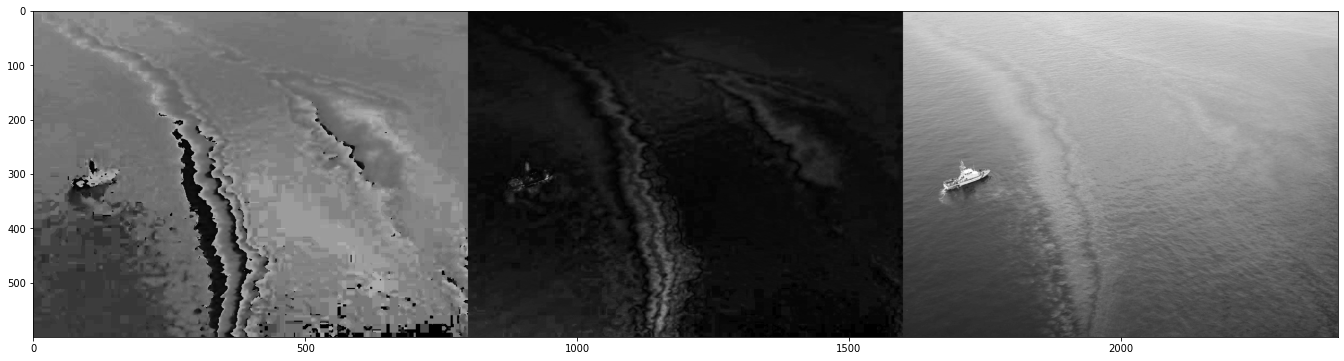

In [2]:
im = cv2.cvtColor(cv2.imread('spill_oil.jpg'), cv2.COLOR_BGR2HSV)
plt.figure(1, figsize=(24, 6))
hsv_im = cv2.hconcat([im[..., 0], im[..., 1], im[..., 2]])
plt.imshow(hsv_im, cmap='gray')
plt.show()

From the above HSV representation, it is apparent that V channel has no properties that help distinguish oil spill area from the sea water. H & S channels provide contrasting low and high regions respectively.

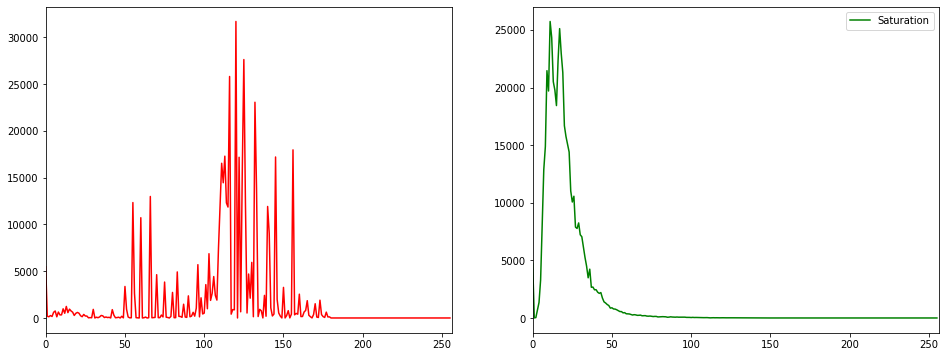

In [3]:
color = {'r': 'Hue','g': 'Saturation'} # in place of H, S
plt.figure(figsize=(16, 6))
for i,col in enumerate(color):
    plt.subplot(1,2,i+1)
    histr = cv2.calcHist([im],[i],None,[256],[0,256])
    plt.plot(histr,color = col, label=color[col])
    plt.xlim([0,256])
plt.legend()
plt.show()

### Testing out techniques to improve per-channel contrast with histogram equalization

Applying histogram equalization to improve contrast

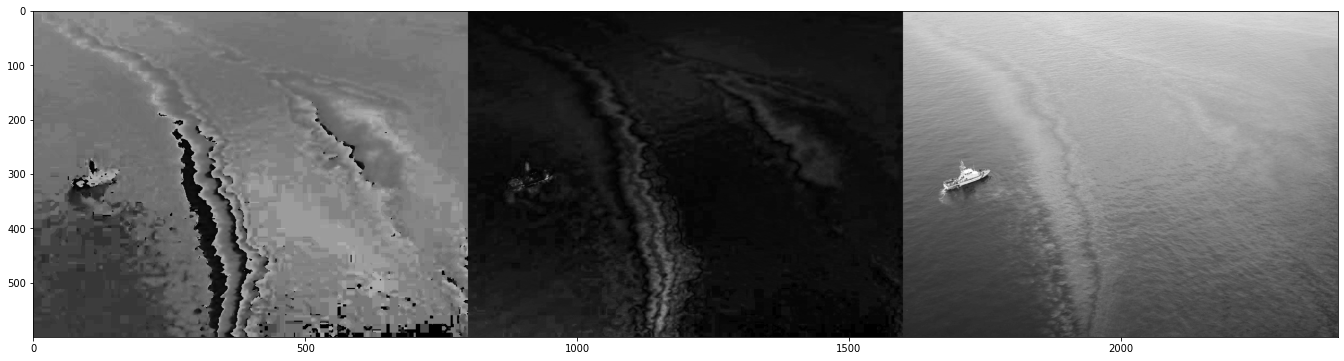

In [4]:
im = cv2.cvtColor(cv2.imread('spill_oil.jpg'), cv2.COLOR_BGR2HSV)
plt.figure(1, figsize=(24, 6))
equalized_hsv_im = cv2.hconcat([cv2.equalizeHist(im[..., 0]), cv2.equalizeHist(im[..., 1]), im[..., 2]])
plt.imshow(hsv_im, cmap='gray')
plt.show()

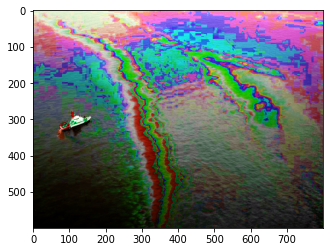

In [5]:
clahe_im = cv2.merge([cv2.equalizeHist(im[..., 0]), cv2.equalizeHist(im[..., 1]), cv2.equalizeHist(im[..., 2])])
plt.imshow(cv2.cvtColor(clahe_im, cv2.COLOR_HSV2RGB))

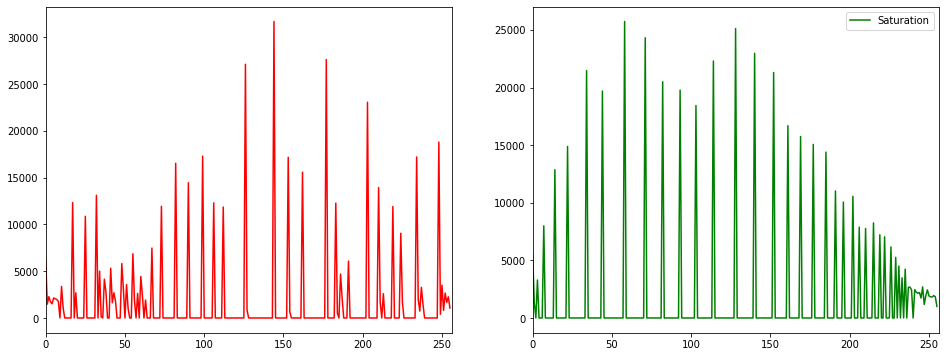

In [6]:
color = {'r': 'Hue','g': 'Saturation'} # in place of H, S
plt.figure(figsize=(16, 6))
for i,col in enumerate(color):
    plt.subplot(1,2,i+1)
    histr = cv2.calcHist([clahe_im],[i],None,[256],[0,256])
    plt.plot(histr,color = col, label=color[col])
    plt.xlim([0,256])
plt.legend()
plt.show()

## Isolating Oil Spill area in the given image

### Denoising the Image

Image filtering is used to reduce the noise in the image using Blur, Gaussian Blur and Median filters, using kernel size of 5.

Kernal size is set to 5, as it offers the best balance between distinct colors while reducing the effect of sun light reflected off by the water. 

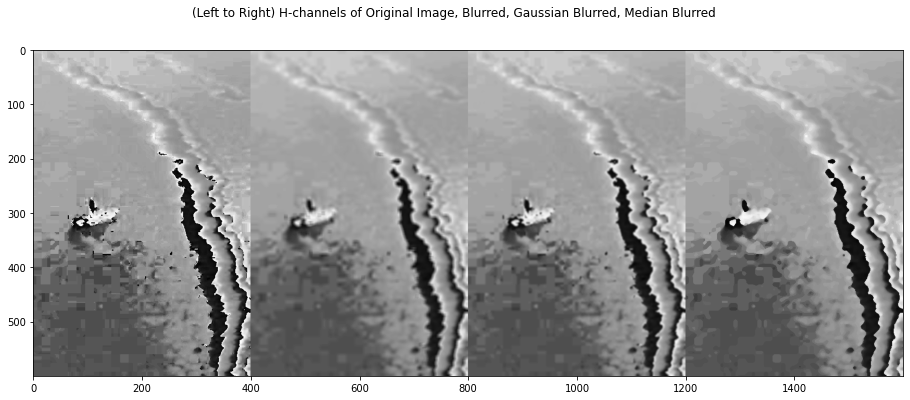

In [7]:
h_im = im[:, :400, 0].copy()

K = 7
blur_im = cv2.blur(h_im, (K, K))
gblur_im = cv2.GaussianBlur(h_im, (K, K), 0)
mblur_im = cv2.medianBlur(h_im, K)
new_h_im = cv2.hconcat([h_im, blur_im, gblur_im, mblur_im])

plt.figure(1, figsize=(16, 6))
plt.suptitle('(Left to Right) H-channels of Original Image, Blurred, Gaussian Blurred, Median Blurred')
plt.imshow(new_h_im, cmap='gray')
plt.show()

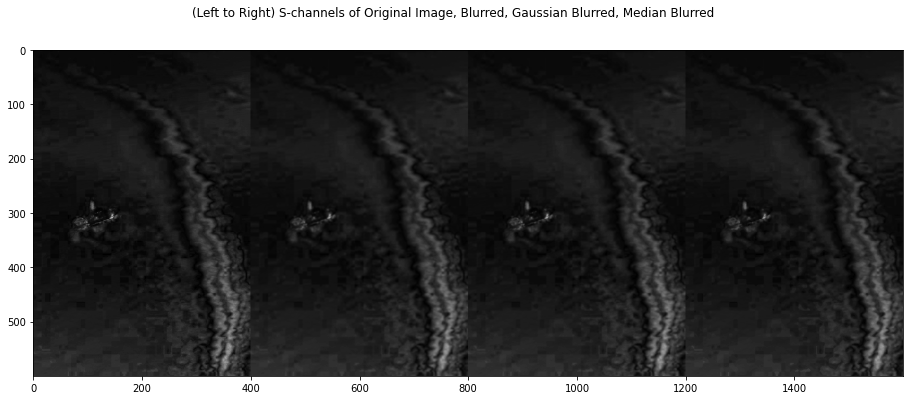

In [8]:
s_im = im[:, :400, 1].copy()

K = 3
blur_im = cv2.blur(s_im, (K, K))
gblur_im = cv2.GaussianBlur(s_im, (K, K), 0)
mblur_im = cv2.medianBlur(s_im, K)
new_s_im = cv2.hconcat([s_im, blur_im, gblur_im, mblur_im])

plt.figure(1, figsize=(16, 6))
plt.suptitle('(Left to Right) S-channels of Original Image, Blurred, Gaussian Blurred, Median Blurred')
plt.imshow(new_s_im, cmap='gray')
plt.show()

From the above samples, it seems like plain Blur applied is causing the maximum distortion to both the edges/contours of the oil spill while also causing a decrease in the overall saturation of colors. 

Hue space is benefiting from median blur, which has smoothed out and sharpened the oil spill towards the bottom-right of the image. The effect of blurring on S-space is neutral.

Going ahead, we will focus on median blurred H-space and S-space to augment and highlight oil spill in the image.

### Binarizing the Images

Lets see if binarizing the images will help in segmenting the area of oil spills.

We will compare Manual Thresholding, OTSU and Adaptive Thresholding on Gaussian Blurred and Median Blurred Images.

In [9]:
# On median blurred images
K=5
median_h_im = cv2.medianBlur(h_im, K)
median_s_im = cv2.medianBlur(s_im, K)

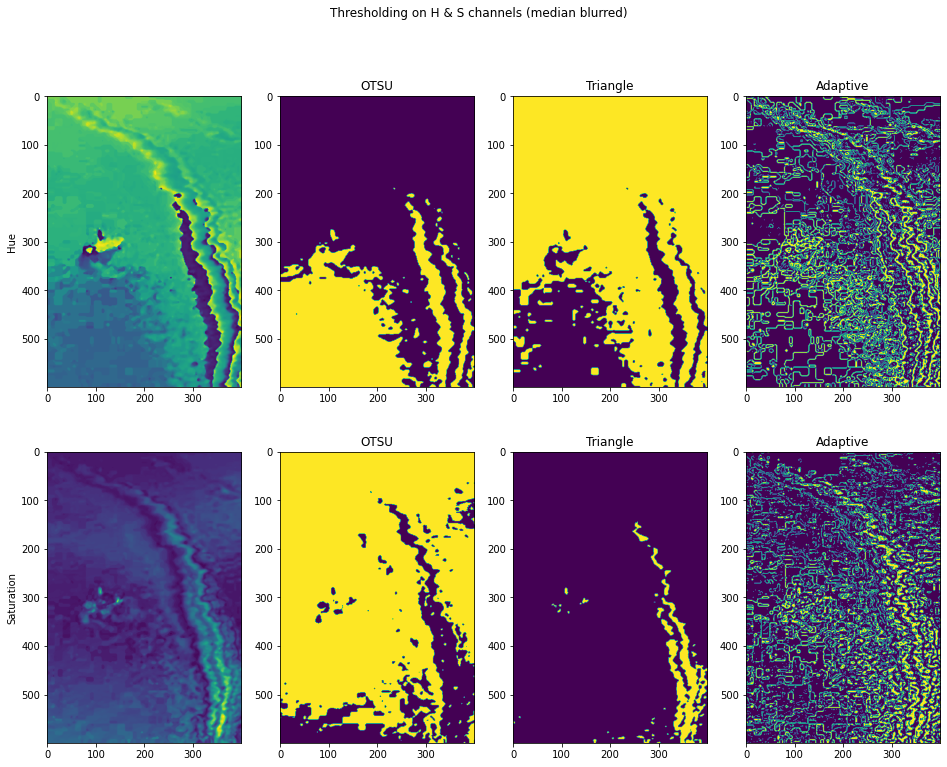

In [10]:
plt.figure(1, figsize=(16, 12))
plt.suptitle('Thresholding on H & S channels (median blurred)')
for id, (ch_name, ch_im) in enumerate([('Hue', median_h_im), ('Saturation', median_s_im)]):
  plt.subplot(2,4,id*4+1)
  plt.ylabel(ch_name)
  plt.imshow(ch_im)
  plt.subplot(2,4,id*4+2)
  plt.title('OTSU')
  otsu_thres, otsu_im = cv2.threshold(ch_im, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
  plt.imshow(otsu_im)
  plt.subplot(2,4,id*4+3)
  plt.title('Triangle')
  tri_thres, tri_im = cv2.threshold(ch_im, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_TRIANGLE)
  plt.imshow(tri_im)
  plt.subplot(2,4,id*4+4)
  plt.title('Adaptive')
  adp_im = cv2.adaptiveThreshold(ch_im, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 0)
  plt.imshow(adp_im)
plt.show()

In [11]:
# On Gaussian blurred images
K=5
median_h_im = cv2.GaussianBlur(h_im, (K, K), 0)
median_s_im = cv2.GaussianBlur(s_im, (K, K), 0)

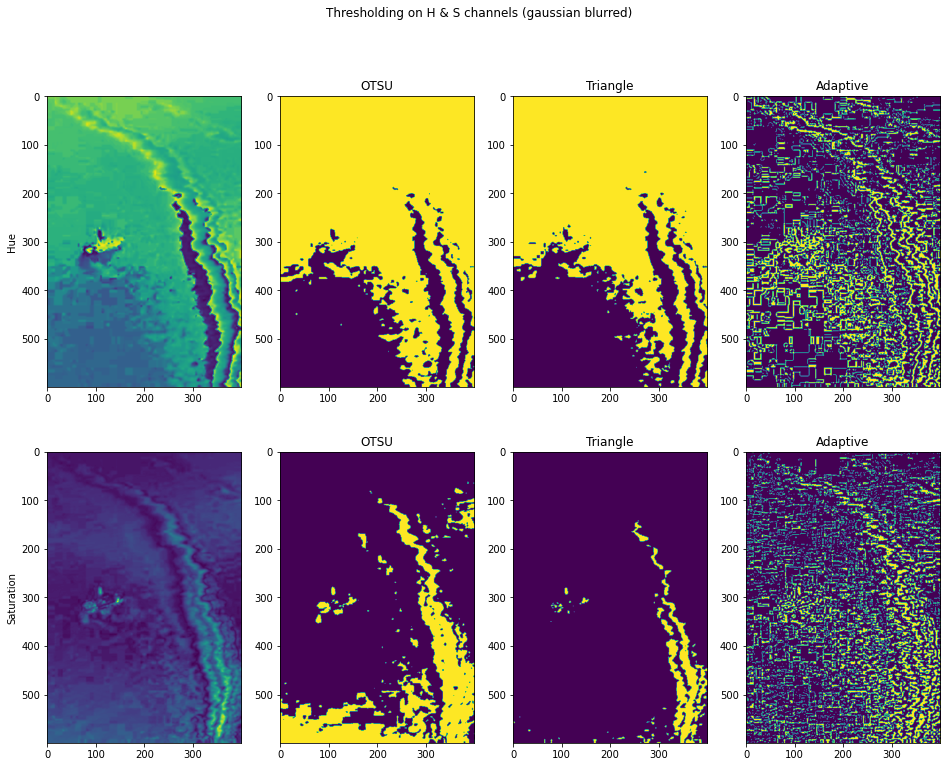

In [12]:
plt.figure(1, figsize=(16, 12))
plt.suptitle('Thresholding on H & S channels (gaussian blurred)')
for id, (ch_name, ch_im) in enumerate([('Hue', median_h_im), ('Saturation', median_s_im)]):
  plt.subplot(2,4,id*4+1)
  plt.ylabel(ch_name)
  plt.imshow(ch_im)
  plt.subplot(2,4,id*4+2)
  plt.title('OTSU')
  otsu_thres, otsu_im = cv2.threshold(ch_im, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
  plt.imshow(otsu_im)
  plt.subplot(2,4,id*4+3)
  plt.title('Triangle')
  tri_thres, tri_im = cv2.threshold(ch_im, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_TRIANGLE)
  plt.imshow(tri_im)
  plt.subplot(2,4,id*4+4)
  plt.title('Adaptive')
  adp_im = cv2.adaptiveThreshold(ch_im, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 5, 0)
  plt.imshow(adp_im)
plt.show()

## Conclusion

From above experiments, given the current image, using HSV color space has helped in isolating the oil spill area. Specifically preprocessing Hue and Saturation channels has helped.

### More conclusions
1. Using OTSU and Triangle thresholding on Saturation has provided best results.
2. To train a model on such images, best way would be to train on HSV images rather than RGB. Recommend starting out using an Image Recognition approach with a binary classifier of oil spill present/not present. 